
# MSc Individual Project: Anomaly Detection for Assisted Independent Living

Author: Christina Spanellis
 
Sections 1-4 of this notebook define the necessary method definitions and constants for this project.

Section 5 contains code to build and test the system

## Sections
### 1. [Data preparation and pre-processing](#section1)
### 2. [Anomalous Data Generation Module](#section2)
### 3. [Prediction Module](#section3)
### 4. [Anomaly Detection Module](#section4)
### 5. [Running the system](#section5)

In [3]:
# import the necessary packages for the project
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
import pandas
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np

<a id='section1'></a>
## Section 1: Data preparation and pre-processing

Two different data sets had to be cleaned and prepared to be in a suitable format for the prediction module. 

Data set 1: CASAS HH101

Data set 2: CASAS HH102

The below definitions define the constants and logic needed for loading and pre-processing. 

In [4]:
## CONSTANTS AND GLOBALS DEFINITION

SENSOR_EVENT_WINDOW_SIZE = 19

In [5]:
# load the hh101 data set
def load_hh101():
    # load the data set
    hh101 = read_csv('datasets/hh101/hh101.csv', names=["Sensor",1,2,"Value","Type"])
    hh101.drop(columns={1,2,"Type"}, inplace=True)
    # replace string values and drop unwanted sensor readings
    hh101 = hh101[hh101["Sensor"].str.contains("BAT") == False]
    # hh101 = hh101[hh101["Sensor"] != "D001"]
    # hh101 = hh101[hh101["Sensor"] != "LS010"]
    hh101["Value"] = hh101["Value"].replace({"ON" : 1.0, "OFF" : 0.0})
    hh101["Value"] = hh101["Value"].replace({"ABSENT" : 1.0, "PRESENT" : 0.0})
    hh101["Value"] = hh101["Value"].replace({"OPEN" : 1.0, "CLOSE" : 0.0})
    # creating a mapping of the sensor names to keep track of them
    count = 0
    hh101_sensor_id_mapping = {}
    for sensor in hh101["Sensor"].values:
        if sensor not in hh101_sensor_id_mapping:
            hh101_sensor_id_mapping[sensor] = count
            count+=1
    hh101_reversed_mapping = {y: x for x, y in hh101_sensor_id_mapping.items()}
    return (hh101, hh101_sensor_id_mapping, hh101_reversed_mapping)

# load the hh102 dataset 
def load_hh102():
    # load the data set
    hh102 = read_csv('datasets/hh102/hh102.csv', names=["Sensor",1,2,"Value","Type"])
    hh102.drop(columns={1,2,"Type"}, inplace=True)
    # replace string values and drop unwanted sensor readings
    hh102 = hh102[hh102["Sensor"].str.contains("BAT") == False]
    # hh102 = hh102[hh102["Sensor"] != "D001"]
    # hh102 = hh102[hh102["Sensor"] != "LS010"]
    hh102["Value"] = hh102["Value"].replace({"ON" : 1.0, "OFF" : 0.0})
    hh102["Value"] = hh102["Value"].replace({"ABSENT" : 1.0, "PRESENT" : 0.0})
    hh102["Value"] = hh102["Value"].replace({"OPEN" : 1.0, "CLOSE" : 0.0})
    # creating a mapping of the sensor names to keep track of them
    count = 0
    hh102_sensor_id_mapping = {}
    for sensor in hh102["Sensor"].values:
        if sensor not in hh102_sensor_id_mapping:
            hh102_sensor_id_mapping[sensor] = count
            count+=1
    hh102_reversed_mapping = {y: x for x, y in hh102_sensor_id_mapping.items()}
    return (hh102, hh102_sensor_id_mapping, hh102_reversed_mapping)


This method transforms the data set into a format where the columns represent the various sensor values and segment the data into 20 event sensor windows.

This means that each row in the data set represents the activations for the previous 20 sensor event activations

In [6]:
def transform_data(dataset, sensor_id_mapping):
    data = []
    starting_date_time = datetime.strptime(dataset.index[0], '%Y-%m-%d %H:%M:%S.%f')
    starting_date_time = starting_date_time.replace(microsecond=0)
    sensor_vals = [0.0] * len(sensor_id_mapping)
    event_count = 0 ## counter used to segment the data into sensor event windows
    for i, row in dataset.iterrows():
        curr_date_time =  datetime.strptime(i, '%Y-%m-%d %H:%M:%S.%f')
        curr_date_time = curr_date_time.replace(microsecond=0)
        if (event_count >= SENSOR_EVENT_WINDOW_SIZE):
            values = [starting_date_time.strftime("%m-%d-%Y %H:%M:%S")]
            values.extend(sensor_vals)
            data.append(values)
            starting_date_time = curr_date_time
            sensor_vals = [0.0] * len(sensor_id_mapping)
            event_count = 0
        event_count +=1
        if "D" in row["Sensor"] or "M" in row["Sensor"]:
            if sensor_vals[sensor_id_mapping[row["Sensor"]]] == 0:
                sensor_vals[sensor_id_mapping[row["Sensor"]]] = 1
            else:
                sensor_vals[sensor_id_mapping[row["Sensor"]]] += 1
        else:
                sensor_vals[sensor_id_mapping[row["Sensor"]]] = row["Value"]

    columns = [i for i in range (0,len(sensor_id_mapping))]
    final_columns = ["Time"]
    final_columns.extend(columns)
    # set the index of the dataframe to be the time column
    new_data = pandas.DataFrame.from_records(data, columns=final_columns)
    new_data["Time"] = pandas.to_datetime(new_data["Time"], format='%m-%d-%Y %H:%M:%S')
    new_data = new_data.set_index("Time")
    return new_data   


This method plots all the data (non-normalised) after formatting

In [7]:
def plot_cleaned_data(data, reversed_mapping, name, path):
    changed_legend = data.rename(columns = reversed_mapping)
    ax = changed_legend.plot(subplots=True, figsize=(40,40), title=name.upper() + " sensor values over time.", ylabel="Sensor Value")
    pyplot.tight_layout()
    pyplot.savefig("data_plots/" + name + path, format="png", dpi=1200)

This method transforms the series into a format suitable for a supervised learning problem.

Eg. [Sensor1(t-1), Sensor2(t-1), Sensor1(t), Sensor2(t)]

Where readings at t-1 represent the sensor activations for the period before the activations at t.

Sensor activations at time t then become the ground truth values for activations at t-1 in the prediction module

In [8]:
def transform_series_to_supervised(new_data):
    df = new_data.copy()
    # print(df)
    # scale values
    values = df.values
    min_max_scaler = MinMaxScaler()
    scaled_values = min_max_scaler.fit_transform(values)
    normalized_df = pandas.DataFrame(scaled_values)
    n_vars = len(normalized_df.columns)
    time_Series = normalized_df.copy().set_index(df.index)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(1, 0, -1):
        cols.append(normalized_df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, 1):
        cols.append(normalized_df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return (agg, normalized_df)

This method plots the activations for the sensors in the data set, grouped into figures by sensor type.

In [9]:
def plot_normalised_sensor_activations(dataset_name, normalized_df, reversed_mapping):
    changed_legend = normalized_df.rename(columns = reversed_mapping)
    doors =[]
    lights = []
    temp = []
    motion = []
    for key in reversed_mapping:
        if "D" in reversed_mapping[key]:
            doors.append(key)
        elif "L" in reversed_mapping[key]:
            lights.append(key)
        elif "T1" in reversed_mapping[key]:
            temp.append(key)
        else:
            motion.append(key)
    sensors = [doors, lights, temp, motion]
    names = ["Door Sensors", "Light Sensors", "Temperature Sensors", "Motion Sensors"]
    for i, sensor in enumerate(sensors):
        fig, axs = None, None
        if len(sensor) % 2 == 0 or len(sensor) > 10 :
            fig, axs = pyplot.subplots(int(len(sensor) / 2),2,  sharex=True, sharey=True,figsize=(10,10))
        else:
            fig, axs = pyplot.subplots(len(sensor),1, figsize=(10,10))
        count = 0
        for ax in axs.flat:
            ax.plot(changed_legend[reversed_mapping[sensor[count]]])
            ax.set_title(reversed_mapping[sensor[count]])
            ax.set_xticks([0, 10000, 20000, 30000, 40000, 50000])
            count += 1
        for ax in axs.flat:
            ax.label_outer()
        fig.suptitle(names[i])
        fig.supxlabel("Instance")
        fig.supylabel("Sensor Value")
        pyplot.tight_layout()
        pyplot.savefig("data_plots/" + dataset_name + "/" +names[i],dpi=1200)

Discover the features with the highest correlations

In [10]:

import seaborn as sns
import matplotlib.pyplot as plt

def find_correlations(dataset, path, name, reversed_mapping):
    min_max_scaler = MinMaxScaler()
    scaled_values = min_max_scaler.fit_transform(dataset.values)
    normalized_df = pandas.DataFrame(scaled_values)
    normalized_df = normalized_df.rename(columns = reversed_mapping)
    corrmat = normalized_df.corr(method='pearson', min_periods=100)
    corrmat = np.abs(corrmat)
    sns.set(context="paper", font="monospace")
    f, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(corrmat, vmax=0.8, square=True, xticklabels = True, yticklabels = True)
    pyplot.title(name + " Pearson correlation values between sensors (absolute valued).")
    pyplot.xlabel("Sensor ID")
    pyplot.ylabel("Sensor ID")
    pyplot.tight_layout()
    pyplot.savefig("data_plots/" + path + name)
    triangluar_corrmat = np.triu(corrmat, k=1)
    values = np.where(triangluar_corrmat >= 0.6)
    values = list(zip(values[0], values[1]))
    for x in range (len(values)):
        values[x] = (reversed_mapping[values[x][0]], reversed_mapping[values[x][1]], triangluar_corrmat[values[x][0]][values[x][1]])
    return values 
    

The data needs to be separated out into training (70%), testing (20%) and anomalous portions (10%).

The anomalous portion of the data is held back for synthetic anomaly injection to later be used to test the AD system

In [11]:
def create_train_test_split(dataset, number_features):
    values = dataset.values
    train_split = int(0.7 * len(values))
    anomaly_split = int(0.9 * len(values))

    train = values[:train_split, :]
    test = values[train_split:anomaly_split, :]
    anomalies = values[anomaly_split:, :]

    train_x, train_y = train[:, :number_features], train[:, number_features:]

    test_x, test_y = test[:, :number_features], test[:, number_features:]

    anomaly_x, anomaly_y = anomalies[:, :number_features], anomalies[:, number_features:]

    train_x = np.asarray(train_x).astype(np.float32)
    train_y = np.asarray(train_y).astype(np.float32)
    test_y = np.asarray(test_y).astype(np.float32)
    test_x = np.asarray(test_x).astype(np.float32)
    train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
    test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

    return (train_x, train_y, test_x, test_y, anomaly_x, anomaly_y)


<a id='section3'></a>

## Section 3: Prediction Module

The following section contains the logic to train models for the Prediction Module

A method to save trained models and plot their loss (used for experimentation)

In [12]:
import pickle

def save_model_and_plot(model, filename, history):
    pickle.dump(model, open("prediction_models/" +filename +".sav", 'wb'))
    pyplot.plot(history.history['loss'], label='Loss')
    pyplot.plot(history.history['val_loss'], label='Validation Loss')
    pyplot.xlabel("Epochs")
    pyplot.ylabel("Loss")
    pyplot.title("Loss and Validation loss of prediction model before tuning.")
    pyplot.tight_layout()
    pyplot.legend()
    filename = "prediction_plots/" + filename
    pyplot.savefig(filename)

Creates, trains and saves a model with given parameters

In [13]:
def create_model(train_x, train_y, test_x, test_y, number_features, model_name):
    # design network
    model = Sequential()
    model.add(LSTM(150, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
    model.add(LSTM(75))
    model.add(Dense(number_features))
    model.compile(loss='mean_squared_error', optimizer='adam')
    # fit network
    history = model.fit(train_x, train_y, epochs=100, batch_size=58, validation_split=0.3, verbose=2, shuffle=False)
    # plot history
    save_model_and_plot(model, model_name, history)

    # make a prediction
    yhat = model.predict(test_x)
    test_x = test_x.reshape((test_x.shape[0], number_features))
    print(test_x)
    print(yhat)
    # # calculate RMSE
    rmse = sqrt(mean_squared_error(test_y, yhat))
    print('Test RMSE: %.3f' % rmse)
    return yhat

In [14]:
# from numpy import concatenate
# from math import sqrt
# from sklearn.metrics import mean_squared_error


# # make a prediction
# yhat = model.predict(test_x)
# test_x = test_x.reshape((test_x.shape[0], features))
# print(test_x)
# print(yhat)
# # # calculate RMSE
# rmse = sqrt(mean_squared_error(test_y, yhat))
# print('Test RMSE: %.3f' % rmse)


<a id='section2'></a>
## Section 2: Anomamlous Data Generation Module

The following section contains the logic for the Anomalous Data Generation Module

This method takes the test data and inserts anomalies into a specified fraction of the data

In [15]:
# Try generating some anomalous data
# So decide on the number of anomalous samples.. for example 10
# Then just affect one 20 event sensor window
# One idea is to just scale data to be bigger than 1, in theory this is an anomaly but isn't really in the expected range of input...
# https://github.com/tirthajyoti/Synthetic-data-gen/blob/master/Notebooks/Time%20series%20synthesis%20with%20anomaly.ipynb

 # retrieves the mean, min and max of the different features in the data set
def get_stats(dataset):
    return (dataset.mean(), dataset.min(), dataset.max())

def generate_anomalous_data(stats, anomaly_y, number_features):
    anomaly_frac = 0.2
    anomaly_scale = 1.2
    one_sided = False
    means = stats[0]
    mins = stats[1]
    maxs = stats[2]


    # rows_to_be_modified = new_arr.sample(frac=0.2).values # select (no_anomalies) rows from the data set
    # no_anomalies = len(rows_to_be_modified)
    
    # now need to randomly select one row of datano to alter, so as to not alter the underlying sequence
    anomalous_y = anomaly_y
    for i, row in enumerate(anomalous_y):
        for y, data_point in enumerate(row):
            anomalous_y[i][y] = means[y] + np.random.uniform(low=mins[y], high=anomaly_scale * (maxs[y] - mins[y]))

    return anomalous_y

<a id='section4'></a>
## Section 4: Anomaly Detection Module

This method estimates the likelihood of an anomaly occuring by comparing the predicted value to the ground truth

In [16]:
def detect_anomaly(anomaly_x, anomaly_y, predictions):
    anomaly_free_x_values = anomaly_x
    anomaly_inserted_y_vales = anomaly_y
    
    for i, prediction in enumerate(predictions):
        anomaly_probability = 0.0
        for x, value in enumerate(prediction):
            anomaly_probability += abs(value - anomaly_inserted_y_vales[i][x])
        print("Probability of anomaly: ", anomaly_probability / len(prediction))

<a id='section5'></a>
## Section 5: Running the system

This section contains the code to run the system on data sets 1 and 2 (note these runs use the final model found for the Prediction Module during hyper parameter tuning)

1. [HH101](#hh101)
2. [HH102](#hh102)

<a id='hh101'></a>

### HH101 

In [17]:
hh101, hh101_sensor_id_mapping, hh101_reversed_mapping = load_hh101()
hh101 = transform_data(hh101, hh101_sensor_id_mapping)
hh101_data, plot_data = transform_series_to_supervised(hh101)
train_x, train_y, test_x, test_y, anomaly_x, anomaly_y = create_train_test_split(hh101_data, len(hh101_reversed_mapping))

[('D002', 'M001', 0.7615758480493884),
 ('MA016', 'M002', 0.6676737170085072),
 ('LS010', 'LS001', 0.6353519571008593),
 ('LS009', 'LS014', 0.6321832835360721),
 ('LS005', 'LS013', 0.6341945562575604),
 ('LS006', 'M006', 0.6112256005169898),
 ('M005', 'MA013', 0.6557433106382272),
 ('MA015', 'LS015', 0.6782553207810336)]

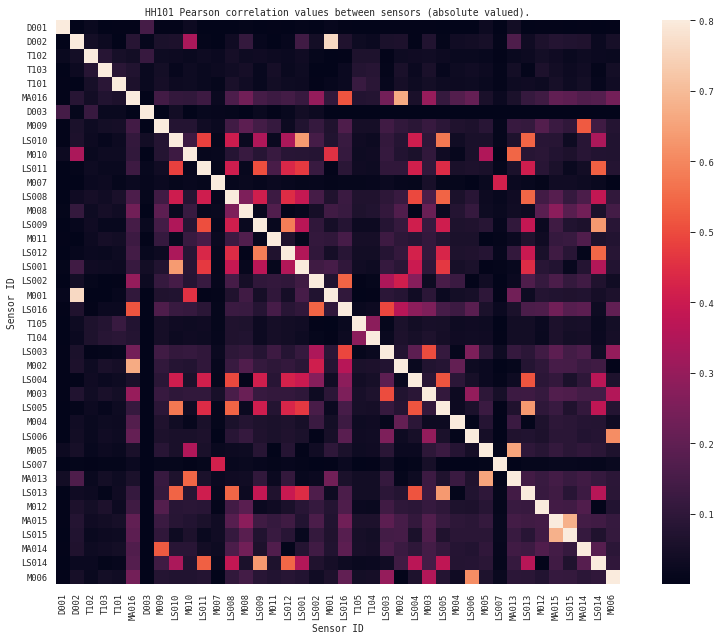

In [18]:
find_correlations(hh101, "hh101/", "HH101", hh101_reversed_mapping)

Running this cell will create various plots of the data set

In [19]:
plot_cleaned_data(hh101, hh101_reversed_mapping, "hh101", "/cleaned_data.png")
plot_normalised_sensor_activations("hh101", plot_data, hh101_reversed_mapping)

<a id='hh102'></a>

### HH102

In [20]:
hh102, hh102_sensor_id_mapping, hh102_reversed_mapping = load_hh102()
hh102 = transform_data(hh102, hh102_sensor_id_mapping)
hh102_data, plot_data = transform_series_to_supervised(hh102)
train_x, train_y, test_x, test_y, anomaly_x, anomaly_y = create_train_test_split(hh102_data, len(hh102_reversed_mapping))

Running this cell will create various plots of the data set

In [21]:
plot_cleaned_data(hh102, hh102_reversed_mapping, "hh102" , "/cleaned_data.png")
plot_normalised_sensor_activations("hh102", plot_data, hh102_reversed_mapping)

[('LS013', 'MA013', 0.7958850899216736),
 ('LS006', 'LS005', 0.66018026961467),
 ('LS010', 'LS011', 0.6809681362850213),
 ('LS015', 'LS016', 0.6702757190772856),
 ('LS014', 'LS012', 0.6010650918922503),
 ('M012', 'M011', 0.8641198425402388),
 ('M012', 'MA010', 0.6058407671063406),
 ('M011', 'MA010', 0.7069451884758535),
 ('MA009', 'LS009', 0.6704467651393416),
 ('MA023', 'LS023', 0.6813427632706398)]

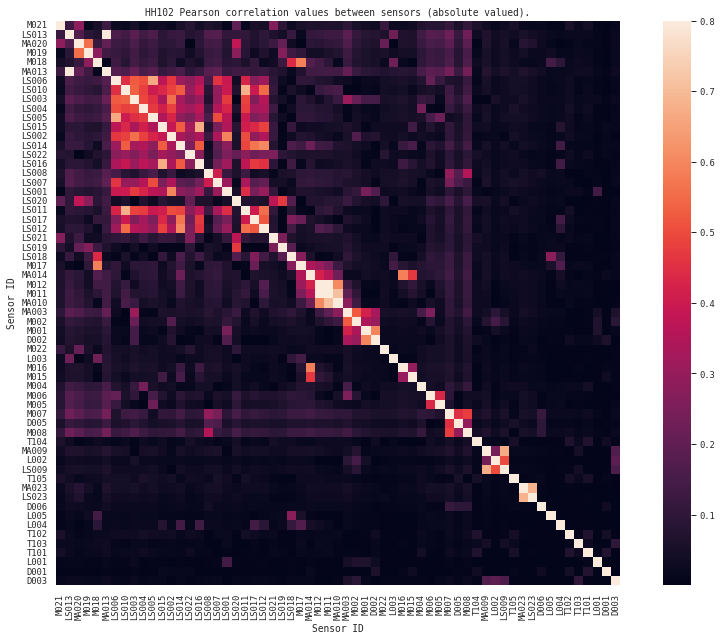

In [22]:
find_correlations(hh102, "hh102/", "HH102", hh102_reversed_mapping)